# Projet sante publique france

## Déjà réalisé

Les données ont été chargée et ont subit un pré-traitement:
   * Les produits ont tous un nom
   * Les données sont désormais dans un fichier `pickle` dans le dossier `data/interim`

## Nettoyage des données 

Les données étant crées par les utilisateurs, les données sont "sales". Il faut retirer toutes les données qui sont des erreurs.

In [1]:
import os
import random
import re
from pprint import pprint

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from tabulate import tabulate
import unicodedata

from src.features.univar import UnivariateAnalysis
from src.utils.parsers import UnitParser
from src.utils.string_handler import StringClustering
from src.visualization import visualize as viz

plt.rcdefaults()
font = {'size': 16}

sns.set()
plt.rc('font', **font)

In [2]:
# On récupère les données du premier traitement
data = pd.read_pickle('../data/interim/products_interim.pickle')

In [3]:
data.shape

(626672, 155)

In [4]:
fields = list(data.columns)
len(fields)

155

nombre minimum et maximum de champs complétés

In [5]:
completness = data.count(axis=1)

In [6]:
completness.name = 'Nombre de champs complétés'

In [7]:
completness.name

'Nombre de champs complétés'

completion rate -- Nombre de champs complétés : 100.0 %


mean,std,min,max,median,variance,25%,75%
36.815870184083536,11.833285118495395,17,96,33.0,140.02663669560457,30.0,43.0


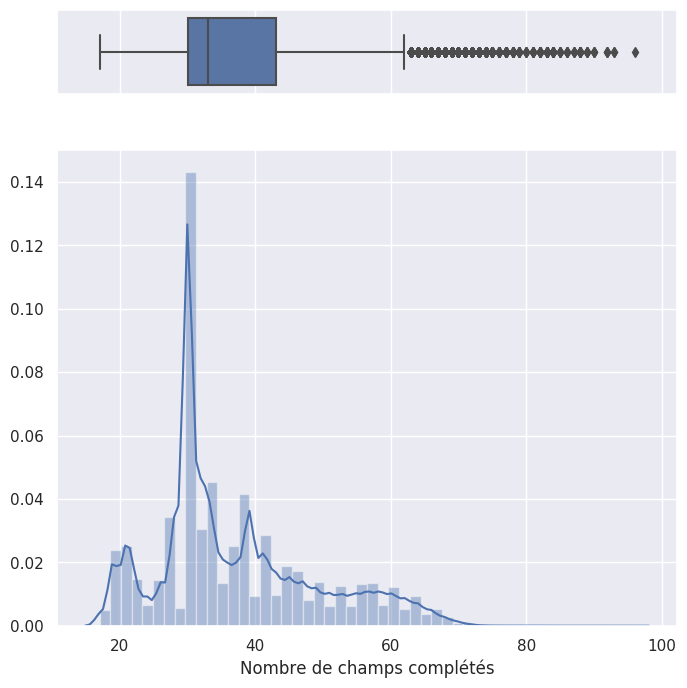

In [8]:
univar = UnivariateAnalysis(pd.DataFrame(completness))
univar.make_analysis('Nombre de champs complétés', save=True)

regardons les champs de plus près

In [9]:
tab = []
row = []
tab_with = 3
for val in data.columns.values[:-2]:
    if len(row) == tab_with:
        tab.append(row)
        row = []
    row.append(val)
while len(row) < tab_with:
    row.append(None)
tab.append(row)
display(HTML(tabulate(tab, tablefmt='html')))

code,url,creator
created_datetime,last_modified_datetime,product_name
generic_name,quantity,packaging
packaging_tags,brands,brands_tags
categories,categories_tags,categories_en
origins,origins_tags,manufacturing_places
manufacturing_places_tags,labels,labels_tags
labels_en,emb_codes,emb_codes_tags
first_packaging_code_geo,cities_tags,purchase_places
stores,countries,countries_tags
countries_en,ingredients_text,allergens


In [10]:
data['pnns_groups_2']

0                       unknown
1                       unknown
3          Dressings and sauces
4                       unknown
5                       unknown
                   ...         
1120745                 unknown
1120746                 unknown
1120747                 unknown
1120749                    Meat
1120750                 unknown
Name: pnns_groups_2, Length: 626672, dtype: object

## Récupération des champs d'intéret

On ne garde que les champs dont on a besoin pour la suite.

In [11]:
general_infos = ['code',
                 'product_name',
                 'brands',
                 'pnns_groups_1',
                 'pnns_groups_2',
                 'quantity',
                 'nutriscore_grade',
                 'main_category_en']

nutri_facts = ['energy_100g',
               'proteins_100g',
               'fat_100g',
               'carbohydrates_100g',
               'salt_100g',
               'sodium_100g',
               'saturated-fat_100g',
               'sugars_100g',
               'fiber_100g']

fields_to_keep = general_infos + nutri_facts

In [12]:
data = data[fields_to_keep]

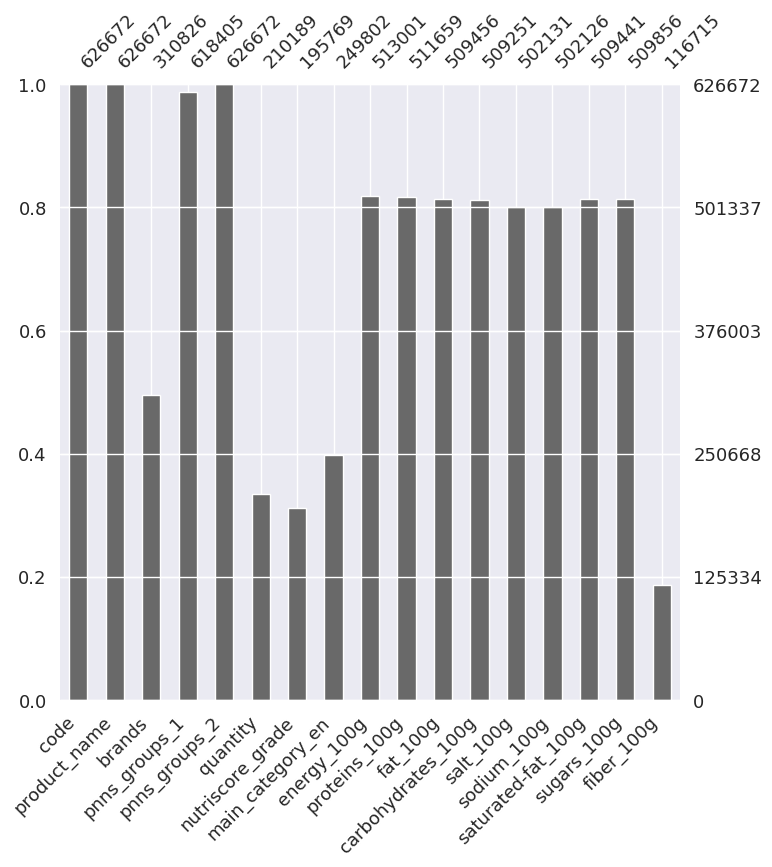

In [13]:
msno.bar(data, figsize=(8, 8), fontsize=13)
plt.savefig('../reports/figures/completness_bar.png', bbox_inches='tight')

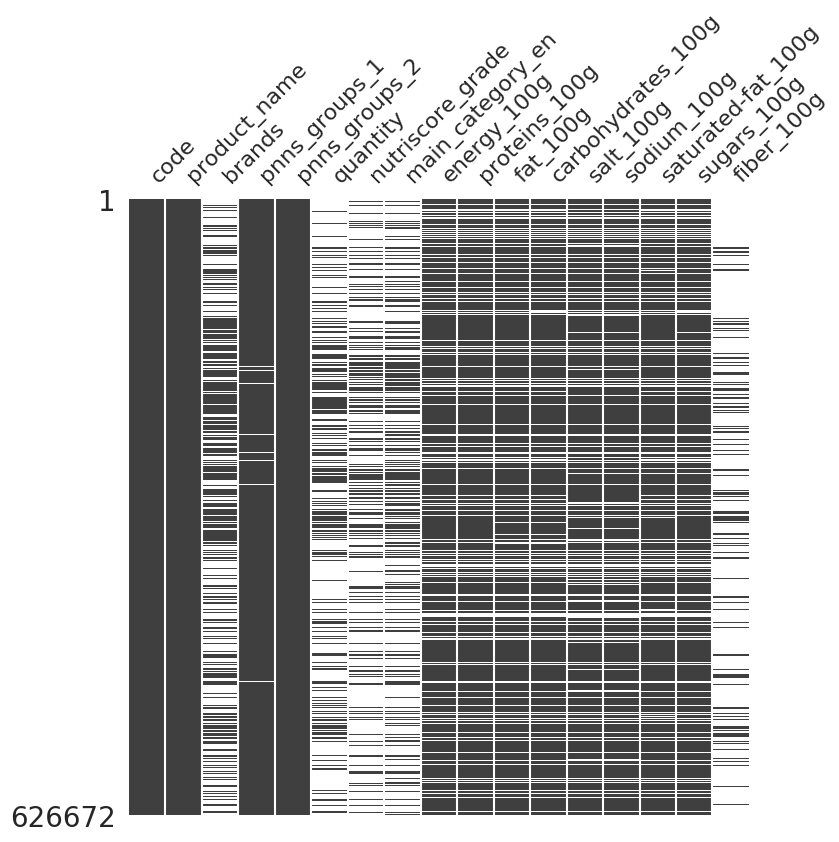

In [14]:
msno.matrix(data, figsize=(8, 8), fontsize=16, sparkline=False)
plt.savefig('../reports/figures/completness.png', bbox_inches='tight')

## Traitement des valeurs manquantes

On retire les produits sans nutriscore, sans valeur energetique, sans quantité et sans catégorie

In [15]:
for field in ['nutriscore_grade', 'energy_100g',
              'quantity', 'main_category_en']:
    print(field)
    data.drop(data.loc[data[field].isna()].index, axis=0, inplace=True)

nutriscore_grade
energy_100g
quantity
main_category_en


On assigne une catégorie "inconnue" pour les produits sans marque et sans groupe PNNS

In [16]:
for field in ['brands', 'pnns_groups_1']:
    print(field)
    data.loc[data[field].isna(), field] = 'unknown'

brands
pnns_groups_1


Pour les champs `*_100g` restant (hormis `energy_100g`) on impute les valeurs manquantes à 0.

In [17]:
for field in nutri_facts[1:]:
    print(field)
    data.loc[data[field].isna(), field] = 0

proteins_100g
fat_100g
carbohydrates_100g
salt_100g
sodium_100g
saturated-fat_100g
sugars_100g
fiber_100g


In [18]:
data.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sodium_100g,saturated-fat_100g,sugars_100g,fiber_100g
count,1.138190e+05,113819.000000,113819.000000,113819.000000,113819.000000,113819.000000,113819.000000,113819.000000,113819.000000
mean,4.222542e+03,8.233680,14.402354,26.058500,0.980750,0.392762,5.634575,12.777445,1.424307
std,1.024734e+06,8.076726,17.713120,26.682605,2.726183,1.100370,8.362874,18.531861,3.332629
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000
25%,4.770000e+02,2.200000,1.500000,3.200000,0.090000,0.036000,0.400000,0.900000,0.000000
50%,1.038000e+03,6.200000,8.000000,13.900000,0.600000,0.240000,2.200000,3.500000,0.000000
75%,1.644000e+03,12.000000,22.000000,50.200000,1.300000,0.520000,8.000000,17.000000,1.800000
max,3.456712e+08,190.000000,330.000000,629.000000,329.692000,131.876800,213.000000,428.000000,129.000000


## Traitement des erreurs

### Quantité

Les quantités sont au format object (string). Va donc parser les chaines de characteres pour éliminer les erreurs
de saisie.

Pour la suite, on va normaliser les chaines de caractères en retirant les accents et autres symboles non latin.

Voir `src.features.parsers.py`

In [19]:
data['quantity'] = data['quantity'].apply(UnitParser.normalize_string)

Les quantités sont entrées sans format. Par conséquent, les unités peuvent être exprimées de plusieurs façons ex: "grammes", "gramme", "gr" pour "g", on crée donc un dictionnaire avec les différentes correspondances trouvées.

Voir `src.features.parsers.py`

In [20]:
data['quantity_tuple'] = data['quantity'].apply(UnitParser.parse)

In [21]:
data['quantity'] = data['quantity_tuple']
data.drop('quantity_tuple', axis=1, inplace=True)

In [22]:
print("Produits ayant un problème de quantité"
      f"{data[data['quantity'] == 'Unknown frmt'].shape[0]}")
percent = data[data['quantity'] == 'Unknown frmt'].shape[0] / data.shape[0]
print(f"Soit {percent * 100} %")

Produits ayant un problème de quantité5652
Soit 4.965778999991214 %


In [23]:
data.drop(data.loc[data['quantity'] == 'Unknown frmt'].index, axis=0, inplace=True)

In [24]:
data.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sodium_100g,saturated-fat_100g,sugars_100g,fiber_100g
count,1.081670e+05,108167.000000,108167.000000,108167.000000,108167.000000,108167.000000,108167.000000,108167.000000,108167.000000
mean,4.396103e+03,8.233607,14.594518,26.355393,0.977296,0.391411,5.697877,12.875297,1.434594
std,1.051165e+06,8.049754,17.919847,26.776896,2.699978,1.090505,8.438818,18.657111,3.318717
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000
25%,4.830000e+02,2.200000,1.550000,3.300000,0.080000,0.032000,0.400000,0.900000,0.000000
50%,1.050000e+03,6.200000,8.000000,14.000000,0.600000,0.240000,2.200000,3.500000,0.000000
75%,1.657000e+03,11.900000,22.700000,51.000000,1.300000,0.520000,8.000000,17.000000,1.800000
max,3.456712e+08,190.000000,330.000000,629.000000,329.692000,131.876800,213.000000,428.000000,129.000000


### Marques

Les marques sont des données catégorielles. On va donc nettoyer le champs par collision de clés (Key collision)

In [25]:
clusters = StringClustering(data['brands'], method="StringFingerPrint")

In [26]:
brands = clusters.get_results()

  0%|          | 13/6613 [00:00<00:54, 120.45it/s]

Detected 6613 clusters with StringFingerPrint 
 Total classes detected 16185.
 Original dataset contains 22795 classes
 There is 9572 orphans.
Create a mapper function this can take a while.


100%|██████████| 98595/98595 [00:00<00:00, 1086503.62it/s]


Replace fingerprint by original name.


In [27]:
data['brands'] = brands

### Catégories

In [28]:
clusters = StringClustering(data['main_category_en'])
categories = clusters.get_results()

  4%|▎         | 13/353 [00:00<00:02, 122.96it/s]

Detected 353 clusters with StringFingerPrint 
 Total classes detected 2107.
 Original dataset contains 2113 classes
 There is 1754 orphans.
Create a mapper function this can take a while.


100%|██████████| 106413/106413 [00:00<00:00, 1221867.02it/s]

Replace fingerprint by original name.


In [29]:
categories.value_counts()

Plant-based foods and beverages                                                          26175
Snacks                                                                                   18800
Dairies                                                                                  12393
Meats                                                                                     8955
Meals                                                                                     6792
                                                                                         ...  
fr:pates-au-ble-complet                                                                      1
fr:pate-a-tartiner-a-la-creme-fraiche                                                        1
fr:boisson-avec-concentre-de-jus-de-fruits-et-puree-de-fruits-avec-vitamines-ajoutees        1
fr:waterzooi                                                                                 1
fr:pain-pre-cuit                                  

In [30]:

def reject_categ(x):
    return x if ":" not in x else None


data['main_category_en'] = categories.apply(reject_categ)

In [31]:
data.drop(data.loc[data['main_category_en'].isna()].index,
          axis=0, inplace=True)

In [32]:
data

,code,product_name,brands,pnns_groups_1,pnns_groups_2,quantity,nutriscore_grade,main_category_en,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sodium_100g,saturated-fat_100g,sugars_100g,fiber_100g
3,0000000000100,moutarde au moût de raisin,courte paille,Fat and sauces,Dressings and sauces,"(100.0, g)",d,Groceries,936.0,5.10,8.2,29.0,4.60,1.811024,2.20,22.0,0.0
305,0000000274739,Raviolini au Fromage de chèvre et Pesto,Comme J’Aime,Composite foods,One-dish meals,"(300.0, g)",b,Meals,455.0,4.40,4.2,12.5,0.60,0.240000,2.10,1.4,1.8
325,0000000491228,Entremets Crème Brulée,Comme j'aime,Milk and dairy products,Dairy desserts,"(20.0, g)",b,Dairies,1952.4,6.80,15.3,75.5,0.50,0.200000,11.20,69.8,0.1
346,00000024,Pommes séchées,Kazidomi,Fruits and vegetables,Dried fruits,"(125.0, g)",c,Plant-based foods and beverages,1222.0,2.00,0.5,65.0,0.03,0.012000,0.10,51.0,0.0
374,0000009125124,Compote de Pomme,Mx3,Fruits and vegetables,Fruits,"(40.0, g)",b,Plant-based foods and beverages,1577.0,1.50,0.5,93.0,0.02,0.008000,0.10,66.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120453,9900010015104,Nectar d'abricot,unknown,Beverages,Fruit nectars,"(100.0, cl)",e,Fruit-juices-and-nectars,218.0,0.50,0.5,11.0,0.02,0.008000,0.10,11.0,0.0
1120651,9971706445611,couronne des rois aux pépites de chocolat,Brioche Pasquier,Sugary snacks,Biscuits and cakes,"(450.0, g)",e,Biscuits and cakes,6540.0,8.21,13.9,53.6,1.00,0.400000,3.75,16.1,0.0
1120673,99877026,Nectar de mangue,Gilbert,Beverages,Sweetened beverages,"(1.0, l)",e,Beverages,213.0,0.50,0.5,12.1,0.03,0.012000,0.00,12.1,0.0
1120721,9999900002553,Chocolat de Couverture Noir,Barry,Sugary snacks,Chocolate products,"(100.0, g)",e,Snacks,2443.0,7.60,46.9,30.7,0.03,0.012000,28.20,26.9,0.0


### PNNS groups

In [33]:
clusters = StringClustering(data['pnns_groups_1'], method='NGramFingerPrint')
groups = clusters.get_results()

ngram_size not specified. Using default value [2]


  0%|          | 0/105498 [00:00<?, ?it/s]

Detected 10 clusters with NGramFingerPrint 
 Total classes detected 10.
 Original dataset contains 14 classes
 There is 0 orphans.
Create a mapper function this can take a while.
Replace fingerprint by original name.


100%|██████████| 105498/105498 [00:00<00:00, 1234889.89it/s]


In [34]:
data.loc[:, 'pnns_groups_1'] = groups

In [35]:
clusters = StringClustering(data['pnns_groups_2'], method='NGramFingerPrint')
groups = clusters.get_results()

ngram_size not specified. Using default value [2]


 33%|███▎      | 13/39 [00:00<00:00, 128.70it/s]

Detected 39 clusters with NGramFingerPrint 
 Total classes detected 39.
 Original dataset contains 45 classes
 There is 0 orphans.
Create a mapper function this can take a while.


100%|██████████| 105498/105498 [00:00<00:00, 1156270.08it/s]

Replace fingerprint by original name.


In [36]:
data.loc[:, 'pnns_groups_2'] = groups

### Données nutritionnelles

In [37]:
data.drop(data[data['sodium_100g'] > data['salt_100g']].index,
          axis=0, inplace=True)

In [38]:
data.drop(data[data['saturated-fat_100g'] > data['fat_100g']].index,
          axis=0, inplace=True)

In [39]:
data.drop(data[data['sugars_100g'] > data['carbohydrates_100g']].index,
          axis=0, inplace=True)

In [40]:
fat = data['fat_100g']
prot = data['proteins_100g']
carbo = data['carbohydrates_100g']
salt = data['salt_100g']

data.drop(data[fat + prot + carbo + salt > 100].index,
          axis=0, inplace=True)

In [41]:
data.shape

(104971, 17)

#### Valeurs énergétiques [0, 4000]

In [42]:
data.drop(data[data['energy_100g'] > 4000].index, axis=0, inplace=True)

#### Données nutritionnelles au 100g [0, 100]

In [43]:
for field in nutri_facts[1:]:
    print(field)
    data.drop(data[data[field] > 100].index, axis=0, inplace=True)

proteins_100g
fat_100g
carbohydrates_100g
salt_100g
sodium_100g
saturated-fat_100g
sugars_100g
fiber_100g


### Produits dupliqués

In [44]:
data[data['code'].duplicated()]

,code,product_name,brands,pnns_groups_1,pnns_groups_2,quantity,nutriscore_grade,main_category_en,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sodium_100g,saturated-fat_100g,sugars_100g,fiber_100g
331023,2559656003005,chorizo bio,el bardalejo,Fish Meat Eggs,Processed meat,"(300.0, g)",e,Meats,1954.0,36.0,35.0,2.0,3.5,1.4,13.5,1.0,0.0


In [45]:
data[data['code'] == '2559656003005']

,code,product_name,brands,pnns_groups_1,pnns_groups_2,quantity,nutriscore_grade,main_category_en,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sodium_100g,saturated-fat_100g,sugars_100g,fiber_100g
331022,2559656003005,chorizo bio,el bardalejo,Fish Meat Eggs,Processed meat,"(300.0, g)",e,Meats,1954.0,36.0,35.0,2.0,3.5,1.4,13.5,1.0,0.0
331023,2559656003005,chorizo bio,el bardalejo,Fish Meat Eggs,Processed meat,"(300.0, g)",e,Meats,1954.0,36.0,35.0,2.0,3.5,1.4,13.5,1.0,0.0


In [46]:
data.drop_duplicates('code', inplace=True)

## Sauvegarde 

In [47]:
print(f"Le fichier contient maintenant {data.shape[0]}"
      f" lignes et {data.shape[1]} colonnes")

Le fichier contient maintenant 104897 lignes et 17 colonnes


In [48]:
data.to_pickle("../data/interim/products_interimV2.pickle")

Version control

In [49]:
!git commit ./2.0-tg-data-cleaning.ipynb -m "Automatic commit"

[master d22b48f] Automatic commit
 1 file changed, 1315 insertions(+), 1926 deletions(-)
 rewrite notebooks/2.0-tg-data-cleaning.ipynb (74%)
